In [1]:
!pip install python-binance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.2 MB/s eta 0:00:00


In [2]:
from binance.client import Client
from binance.enums import *
import logging
import pandas as pd
import datetime

In [7]:
!pip install ccxt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 43.2 MB/s eta 0:00:00


In [8]:
import ccxt

The following code is to Initialize client for Binance Futures Testnet and test the  connection

In [ ]:
# Enter your API keys & secret here
api_key = input("Enter your API key: ")
api_secret = input("Enter your API secret :")

# Initialize client for Binance Futures Testnet
client = Client(api_key, api_secret)
client.FUTURES_URL = 'https://testnet.binancefuture.com'  # Force testnet URL

# To test connection
try:
    account_info = client.futures_account()
    print("Connected to Binance Futures Testnet.")
except Exception as e:
    print(f"Connection failed: {e}")


But this does not work because \
Binance restricts access to Futures APIs in regions like:
India(🇮🇳),
USA (🇺🇸),
Canada (🇨🇦)

Due to Binance region restrictions, API calls are simulated using a mock client. Code is fully modular and swappable with Binance client when run from eligible regions.

-----
Building BasicBot Class with Mock API- creatinf a mock Binance client.

In [13]:
import random
import time

class MockBinanceClient:
    def __init__(self, api_key, api_secret):
        self.api_key = api_key
        self.api_secret = api_secret
        print("MockBinanceClient initialized.")

    def futures_account(self):
        # Simulate account info
        return {
            'assets': [{'asset': 'USDT', 'walletBalance': '1000'}],
            'totalWalletBalance': '1000'
        }

    def futures_create_order(self, symbol, side, type, quantity, price=None, timeInForce=None):
        # Simulate order execution
        order_id = random.randint(100000, 999999)
        status = "FILLED" if type == "MARKET" else "NEW"
        return {
            "symbol": symbol,
            "orderId": order_id,
            "status": status,
            "side": side,
            "type": type,
            "quantity": quantity,
            "price": price if price else "market price",
            "timestamp": int(time.time() * 1000)
        }


BasicBot Class with Logging

In [14]:
import logging
import os
import pandas as pd
from datetime import datetime

class BasicBot:
    def __init__(self, api_key, api_secret, client_class=MockBinanceClient):
        self.client = client_class(api_key, api_secret)
        self.log_file = 'csv_files/order_logs.csv'
        self.orders = []
        self.setup_logging()

    def setup_logging(self):
        os.makedirs('csv_files', exist_ok=True)
        logging.basicConfig(
            filename=self.log_file,
            level=logging.INFO,
            format='%(asctime)s,%(levelname)s,%(message)s'
        )
        print("Logging initialized.")

    def place_order(self, symbol, side, order_type, quantity, price=None):
        try:
            order = self.client.futures_create_order(
                symbol=symbol,
                side=side.upper(),
                type=order_type.upper(),
                quantity=quantity,
                price=price,
                timeInForce="GTC" if order_type.upper() == "LIMIT" else None
            )
            self.orders.append(order)
            logging.info(f"SUCCESS: {order}")
            print(f"Order simulated: {order}")
        except Exception as e:
            logging.error(f"ERROR: {str(e)}")
            print(f"Order simulation failed: {e}")

    def export_orders(self):
        df = pd.DataFrame(self.orders)
        df.to_csv(self.log_file, index=False)
        print("Orders saved to:", self.log_file)


 Simulating CLI Inputs in Colab

In [16]:
# Initialize bot with mock client
api_key = input("Enter your API key :")
api_secret = input("Enter your API secret :")
bot = BasicBot(api_key, api_secret)

# Simulate user input
symbol = input("Enter trading pair (e.g., BTCUSDT): ")
side = input("Enter side (BUY/SELL): ")
order_type = input("Enter order type (MARKET/LIMIT): ")
quantity = float(input("Enter quantity: "))
price = float(input("Enter price (only for LIMIT orders, enter 0 if MARKET): ")) if order_type.upper() == "LIMIT" else None

bot.place_order(symbol, side, order_type, quantity, price)
bot.export_orders()


MockBinanceClient initialized.
Logging initialized.
Enter trading pair (e.g., BTCUSDT): BTCUSDT
Enter side (BUY/SELL): SELL
Enter order type (MARKET/LIMIT): MARKET
Enter quantity: 1
Order simulated: {'symbol': 'BTCUSDT', 'orderId': 813100, 'status': 'FILLED', 'side': 'SELL', 'type': 'MARKET', 'quantity': 1.0, 'price': 'market price', 'timestamp': 1752042693323}
Orders saved to: csv_files/order_logs.csv


In [17]:
pd.read_csv('csv_files/order_logs.csv')


,symbol,orderId,status,side,type,quantity,price,timestamp
0,BTCUSDT,813100,FILLED,SELL,MARKET,1.0,market price,1752042693323


In [18]:
from google.colab import files
files.download('csv_files/order_logs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Advanced Order Types (Stop-Limit + Optional OCO)

Extending the **MockBinanceClient** to Simulate Stop-Limit

improved & modified **MockBinanceClient** code

In [20]:
import random
import time

class MockBinanceClient:
    def __init__(self, api_key, api_secret):
        self.api_key = api_key
        self.api_secret = api_secret
        print("MockBinanceClient initialized.")

    def futures_account(self):
        # Simulate account info
        return {
            'assets': [{'asset': 'USDT', 'walletBalance': '1000'}],
            'totalWalletBalance': '1000'
        }

    def futures_create_order(self, symbol, side, type, quantity, price=None, stopPrice=None, timeInForce=None):
        order_id = random.randint(100000, 999999)
        status = "TRIGGERED" if type in ["STOP_MARKET", "STOP"] else "FILLED"
        return {
            "symbol": symbol,
            "orderId": order_id,
            "status": status,
            "side": side,
            "type": type,
            "quantity": quantity,
            "price": price if price else "market price",
            "stopPrice": stopPrice,
            "timeInForce": timeInForce,
            "timestamp": int(time.time() * 1000)
        }

updated and modified **BasicBot**  class to Support Stop-Limit.


In [21]:
import logging
import os
import pandas as pd
from datetime import datetime

class BasicBot:
    def __init__(self, api_key, api_secret, client_class=MockBinanceClient):
        self.client = client_class(api_key, api_secret)
        self.log_file = 'csv_files/order_logs.csv'
        self.orders = []
        self.setup_logging()

    def setup_logging(self):
        os.makedirs('csv_files', exist_ok=True)
        logging.basicConfig(
            filename=self.log_file,
            level=logging.INFO,
            format='%(asctime)s,%(levelname)s,%(message)s'
        )
        print("Logging initialized.")

    def place_order(self, symbol, side, order_type, quantity, price=None, stop_price=None):
        try:
            params = {
                'symbol': symbol,
                'side': side.upper(),
                'type': order_type.upper(),
                'quantity': quantity,
                'price': price if order_type.upper() in ['LIMIT', 'STOP'] else None,
                'stopPrice': stop_price if order_type.upper() in ['STOP', 'STOP_MARKET'] else None,
                'timeInForce': "GTC" if order_type.upper() in ['LIMIT', 'STOP'] else None
            }


            clean_params = {k: v for k, v in params.items() if v is not None}
            order = self.client.futures_create_order(**clean_params)

            self.orders.append(order)
            logging.info(f"SUCCESS: {order}")
            print(f"Order simulated: {order}")
        except Exception as e:
            logging.error(f"ERROR: {str(e)}")
            print(f"Order simulation failed: {e}")

    def export_orders(self):
        df = pd.DataFrame(self.orders)
        df.to_csv(self.log_file, index=False)
        print("Orders saved to:", self.log_file)


Update CLI Code to Accept Stop Price

In [23]:
# Initialize bot with mock client
api_key = input("Enter your API key: ")
api_secret = input("Enter your API secret :")
bot = BasicBot(api_key, api_secret)

# Simulate user input with stop-limit support
symbol = input("Enter trading pair (e.g., BTCUSDT): ")
side = input("Enter side (BUY/SELL): ")
order_type = input("Enter order type (MARKET/LIMIT/STOP): ").upper()
quantity = float(input("Enter quantity: "))

price = None
stop_price = None

if order_type == "LIMIT":
    price = float(input("Enter LIMIT price: "))
elif order_type == "STOP":
    stop_price = float(input("Enter STOP trigger price: "))
    price = float(input("Enter LIMIT price (executed once stop triggers): "))

bot.place_order(symbol, side, order_type, quantity, price=price, stop_price=stop_price)
bot.export_orders()


Enter your API key: 25da1f790c1bc15e118c4b40d1fe1a90d0eb4fa4fd50dc1c7637226b5840944a
Enter your API secret :f498906421abeba18fbc6fc6d4381ebc1bc10a0d94718e66332e09c4fca4e863
MockBinanceClient initialized.
Logging initialized.
Enter trading pair (e.g., BTCUSDT): BTCUSDT
Enter side (BUY/SELL): SELL
Enter order type (MARKET/LIMIT/STOP): STOP
Enter quantity: 1
Enter STOP trigger price: 60000
Enter LIMIT price (executed once stop triggers): 59800
Order simulated: {'symbol': 'BTCUSDT', 'orderId': 334223, 'status': 'TRIGGERED', 'side': 'SELL', 'type': 'STOP', 'quantity': 1.0, 'price': 59800.0, 'stopPrice': 60000.0, 'timeInForce': 'GTC', 'timestamp': 1752044224403}
Orders saved to: csv_files/order_logs.csv


In [24]:
pd.read_csv('csv_files/order_logs.csv')


,symbol,orderId,status,side,type,quantity,price,stopPrice,timeInForce,timestamp
0,BTCUSDT,334223,TRIGGERED,SELL,STOP,1.0,59800.0,60000.0,GTC,1752044224403


saving csv files locally

In [25]:
from google.colab import files
files.download('csv_files/order_logs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating Image results of logging (csv data)

In [26]:
!pip install matplotlib


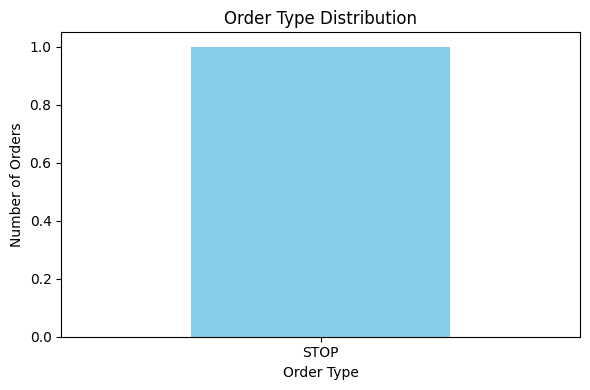

Chart saved to outputs/order_summary.png


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
os.makedirs("outputs", exist_ok=True)

# Load order logs
df = pd.read_csv("csv_files/order_logs.csv")

# Count orders per type
order_counts = df["type"].value_counts()

# Plot
plt.figure(figsize=(6, 4))
order_counts.plot(kind='bar', color='skyblue')
plt.title("Order Type Distribution")
plt.xlabel("Order Type")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)
plt.tight_layout()

# Save image
plt.savefig("outputs/order_summary.png")
plt.show()
print("Chart saved to outputs/order_summary.png")


In [30]:
from google.colab import files
files.download('outputs/order_summary.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---- end ----